# Analyse Marché Automobile LeBonCoin

### Description du Projet

Dans le contexte de l'achat d'une voiture d'occasion avec un budget restreint, ce notebook a été élaboré pour analyser les données des annonces du site Le Bon Coin. Il vise à étudier les tendances des prix des véhicules, à identifier les principaux facteurs influençant ces prix, et à développer un modèle de régression simple et interprétable pour prédire le prix d'une voiture en fonction de caractéristiques telles que la marque, le modèle, le kilométrage et l'année de mise en circulation.

### Questions clés :
- Quels sont les facteurs principaux qui influencent le prix des voitures d'occasion ?
- Peut-on identifier des opportunités d'achat sous-évaluées sur la plateforme ?

### Source


Les données utilisées proviennent du site LeBonCoin, un site d'annonces en ligne populaire en France, notamment pour la vente de voitures d'occasion. Les données ont été collectées via un script de scraping, en se concentrant sur les voitures dont le prix est inférieur ou égal à 20 000 euros et dont l'année de construction est postérieure à 2010. Les données sont conservées sous la forme d'un fichier Excel.


Lien vers le site LeBonCoin : https://www.leboncoin.fr/

### Objectifs Principaux 
1. [Importation des bibliothèques & Données](#importing)
* Importation des bibliothèques Python et des fonctions développées dans le répertoire src
* Chargement et aperçu des données depuis un fichier Excel
2. [Analyse exploratoire des données (EDA)](#exploration) :
* Visualiser la répartition des véhicules par marque, modèle, région, carburant, etc
* Visualiser les tendances de prix moyen en fonction des différentes variables
3. [Prétraitement des données](#pretraitement) :
* Gérer les valeurs manquantes, les doublons et les outliers
* Transformer les variables catégorielles en format numérique pour la modélisation
4. [Modélisation](#modelisation) :
* Comparer plusieurs algorithmes de régression pour identifier le modèle le plus performant
* Développer un modèle de régression pour prédire le prix des voitures
5. [Interprétation des résultats](#resultas) :
* Comprendre les principaux facteurs influençant les prix des véhicules
* Synthétiser les résultats et tirer des conclusions pertinentes

<a id="importing"></a>
## 1. Importation des bibliothèques & Données
### 1.1 Importation des bibliothèques 

In [1]:
# Gestion des avertissements
import warnings
warnings.filterwarnings("ignore")

# Gestion des chemins et du système
import os
import sys

# Ajout du chemin vers le dossier "src" pour permettre l'import
sys.path.append(os.path.abspath("../src"))

# Traitement des données
import numpy as np
import pandas as pd

# Visualisation des données
import seaborn as sns
sns.set()

# Modélisation et évaluation
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Import des fonctions spécifiques aux scripts personnalisés
from data_viz import countplots, plot_avg_price, plot_comparative_price, plot_price_evolution
from numeric_viz import plot_numeric_boxplots, plot_numeric_distributions, plot_correlation_matrix
from preprocess_data import (
    remove_rare_categories,
    preprocess_car_model,
    merge_categories,
    process_categorical,
    impute_by_car_model,
    impute_with_random_forest,
    extract_additional_information,
    missing_data)
from ml_tools import (compare_regression_models, visualize_model_performance, plot_feature_importance,
                      visualize_coefficients, optimize_model)


### 1.2 Chargement des données

In [2]:
data = pd.read_excel('../data/annonces_voitures_leboncoin.xlsx')
data.head()

,list_id,first_publication_date,status,region_name,city,owner_type,u_car_brand,u_car_model,regdate,mileage,fuel,gearbox,vehicle_type,vehicule_color,doors,seats,horsepower,horse_power_din,body,price
0,2857280820,2024-10-02 08:43:00,active,Provence-Alpes-Côte d'Azur,Nice 06000 Ventabrun,pro,CITROEN,C1,2018,6500 km,Essence,Manuelle,Berline,Rouge,5.0,4,4 Cv,82 Ch,INFORMATIONS IMPORTANTES\n- Les visites de véh...,9990
1,2857048646,2024-10-01 15:21:00,active,Bretagne,La Gacilly 56200,pro,DACIA,Spring,2021,11841 km,Electrique,Automatique,"4x4, SUV & Crossover",Gris,5.0,4,2 Cv,45 Ch,"Dacia SPRING BUSINESS 2020 - ACHAT INTEGRAL, G...",8490
2,2855220935,2024-09-28 11:47:00,active,Picardie,Rantigny 60290,pro,MINI,Countryman,2014,140000 km,Diesel,Manuelle,"4x4, SUV & Crossover",Blanc,5.0,5,7 Cv,143 Ch,Mini Countryman MINI COOPER SD 2.0L DPF 143cv ...,9990
3,2854655371,2024-09-27 07:33:00,active,Nord-Pas-de-Calais,Roncq 59223,pro,RENAULT,Zoe,2019,49584 km,Electrique,Automatique,Berline,Gris,5.0,5,1 Cv,NaN,Renault Zoe Life charge normale R90 MY19 berli...,9999
4,2854434333,2024-09-27 15:24:00,active,Limousin,Allassac 19240,pro,PEUGEOT,2008,2015,153890 km,Diesel,Manuelle,"4x4, SUV & Crossover",Blanc,5.0,5,6 Cv,120 Ch,Peugeot 2008 1.6 BlueHDi 120ch S&S BVM6 Allure...,8990


Voici une courte présentation de quelques colonnes du jeu de données, qui vous aidera à comprendre les informations :


| Colonne                  | Description                               |
|--------------------------|-------------------------------------------|
| list_id                  | Identifiant unique pour chaque annonce    |
| first_publication_date   | Date de publication annonce               |
| region_name              | Région en France où l'annonce a été publiée|
| city                     | Ville en France où l'annonce a été publiée|
| owner_type               | Propriétaire de l'annonce                 |
| u_car_brand              | Marque de véhicule                        |
| u_car_model              | Modèle de véhicule                        |
| regdate                  | Année de construction                     |
| mileage                  | Nombre de kilomètres parcourus            |
| fuel                     | Type de carburant                         |
| gearbox                  | Boite de vitesses                         |
| body                     | Description texte de l'annonce            |
| price                    | Prix de véhicule en euros                 |


### 1.3 Informations Récapitulatives

In [3]:
print('La taille de Dataframe est: ', data.shape)
print('\n')
data.info()

La taille de Dataframe est:  (19050, 20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19050 entries, 0 to 19049
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   list_id                 19050 non-null  int64  
 1   first_publication_date  19050 non-null  object 
 2   status                  19050 non-null  object 
 3   region_name             19050 non-null  object 
 4   city                    19050 non-null  object 
 5   owner_type              19050 non-null  object 
 6   u_car_brand             19035 non-null  object 
 7   u_car_model             18987 non-null  object 
 8   regdate                 19050 non-null  int64  
 9   mileage                 19050 non-null  object 
 10  fuel                    19050 non-null  object 
 11  gearbox                 19050 non-null  object 
 12  vehicle_type            18679 non-null  object 
 13  vehicule_color          18599 non-null  object 


Le jeu de données se compose de 19050 enregistrements, correspondant aux annonces explorées, et comprend 20 colonnes pour les données recueillies.

### 1.4 Visualisation value counts
Pour obtenir une vue d'ensemble sur le jeu de données et un aperçu rapide des 5 valeurs les plus fréquentes :

In [4]:
for col in data.columns:
    if col != 'body':
        print('--- ', col.upper(), ' ---')
        print(data[col].value_counts(normalize=False).head(), '\n\n')



---  LIST_ID  ---
list_id
2812056858    1
2857280820    1
2857048646    1
2855220935    1
2854655371    1
Name: count, dtype: int64 


---  FIRST_PUBLICATION_DATE  ---
first_publication_date
2023-10-24 22:44:06    29
2023-11-09 04:54:09    20
2024-01-18 07:36:50    12
2024-10-13 16:50:44     6
2024-08-07 21:26:00     6
Name: count, dtype: int64 


---  STATUS  ---
status
active    19050
Name: count, dtype: int64 


---  REGION_NAME  ---
region_name
Ile-de-France                 2315
Rhône-Alpes                   1819
Provence-Alpes-Côte d'Azur    1582
Nord-Pas-de-Calais            1451
Pays de la Loire              1328
Name: count, dtype: int64 


---  CITY  ---
city
Saint-Quentin 02100    170
Niort 79000            135
Beauvais 60000         121
Poitiers 86000         109
Calais 62100            92
Name: count, dtype: int64 


---  OWNER_TYPE  ---
owner_type
pro        13784
private     5266
Name: count, dtype: int64 


---  U_CAR_BRAND  ---
u_car_brand
PEUGEOT       4478
RENAULT    

#### Observations
---
* Les annonces sont uniques (Id unique)

* La région Île-de-France regroupe un grand nombre d'annonces de véhicules

* La majorité des annonces sont publiées par des professionnels

* Les marques PEUGEOT, RENAULT et CITROEN dominent le marché

* Le modèle le plus courant dans les annonces est la PEUGEOT 208
 


### 1.5 Data Preprocessing
---
Pour optimiser la visualisation et l'interprétation des résultats, nous allons effectuer quelques ajustements en fonction des données observées :

* Renommer les colonnes : u_car_brand devient car_brand, u_car_model devient car_model, et regdate devient car_year

* Prétraiter la colonne car_model en combinant la marque et le modèle de la voiture

* Prétraiter les colonnes mileage, horsepower, horse_power_din, et seats en les convertissant en numérique

#### Code d'application 

In [5]:
#Renommé les colonnes : u_car_brand => car_brand, regdate => "car_year"
data = data.rename(columns={"u_car_brand": "car_brand", "regdate": "car_year"})

#Prétraitement de la colonne car_model (combine la marque et le modèle de la voiture)
data['car_model']=data['car_brand'] + ' ' + data['u_car_model']

#Prétraitement des colonnes 'mileage','horsepower','seats' 'horse_power_din' (convertir en numérique)
data['mileage'] = pd.to_numeric(data['mileage'].astype(str).str.replace('[^\d]', '', regex=True))
data['horsepower'] = pd.to_numeric(data['horsepower'].astype(str).str.replace('[^\d]', '', regex=True))
data['seats'] = pd.to_numeric(data['seats'].astype(str).str.replace('[^\d]', '', regex=True))
data['horse_power_din'] = pd.to_numeric(data['horse_power_din'].astype(str).str.replace('[^\d]', '', regex=True))

#Mélanger les données 
data = shuffle(data, random_state=444)
data=data.reset_index(drop=True)

<a id="exploration"></a>
## 2. Analyse exploratoire des données
### 2.1 Visualiser la répartition des véhicules

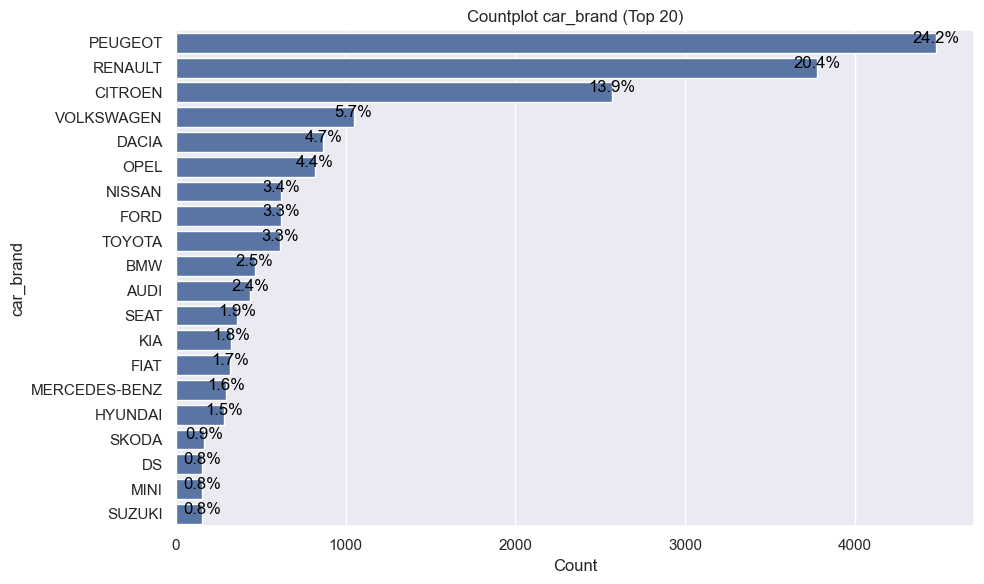

In [9]:
# Appeler la fonction countplots pour tracer la répartition des marques de voitures
countplots(data,columns=['car_brand'], top_n=20, figsize=(10, 6))

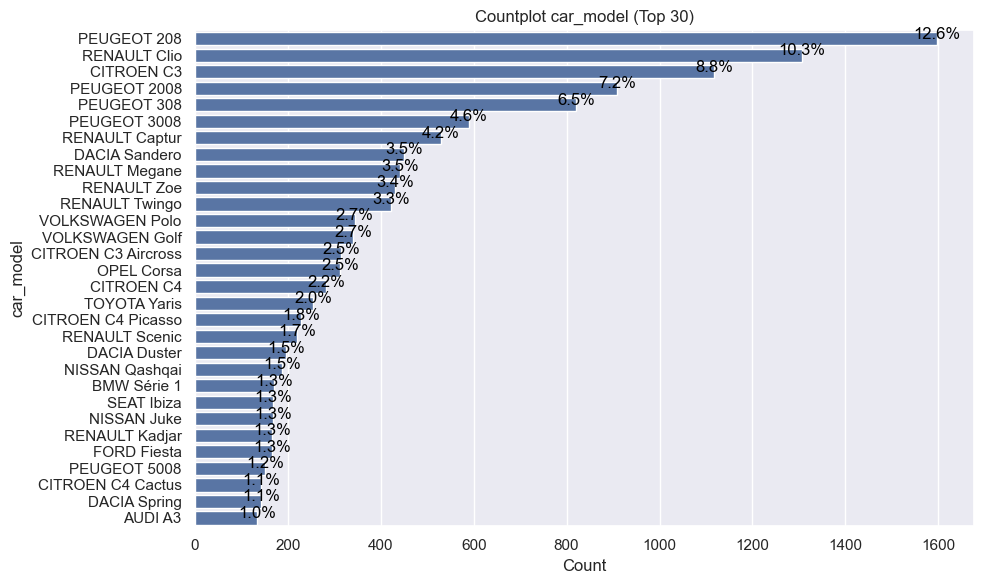

In [10]:
# # Appeler la fonction countplots pour tracer la répartition des modèles de voitures
countplots(data,['car_model'], top_n=30, figsize=(10, 6))

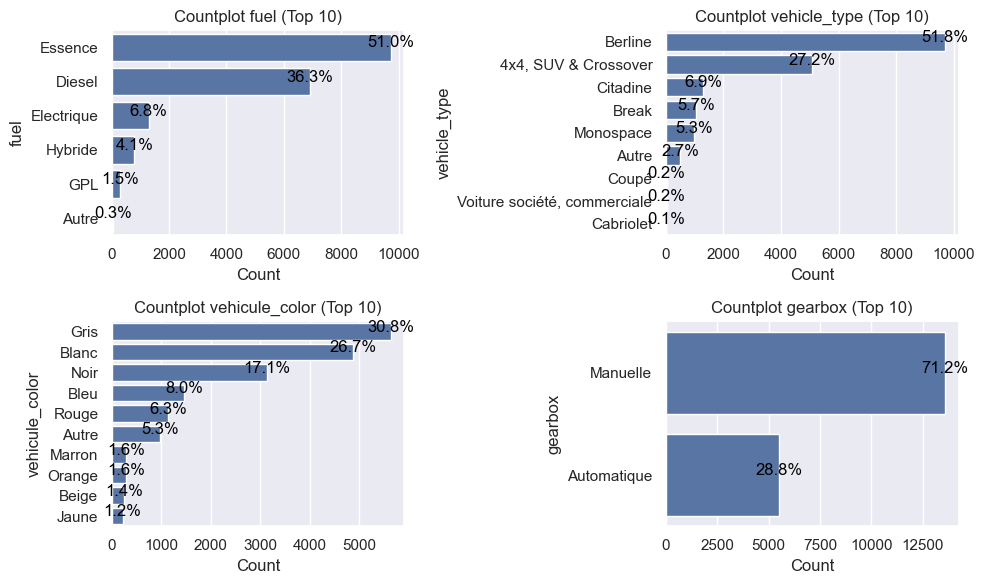

In [11]:
# Appeler la fonction countplots pour tracer la répartition de fuel,vehicle_type,vehicule_color,gearbox
countplots( data, ['fuel','vehicle_type','vehicule_color','gearbox' ], top_n=10, figsize=(10, 6))

### Observations
---
Les graphiques montrent la répartition des différentes variables catégorielles dans l'ensemble des données, comme la marque, le modèle et le type de carburant, facilitant l'identification des catégories les plus fréquentes et les moins fréquentes :

* PEUGEOT, RENAULT et CITROEN sont les marques les plus répandues.
* La PEUGEOT 208 est en tête des modèles, représentant 13 % des annonces.
* Environ 87 % des voitures sont alimentées par essence ou diesel.
* Plus de la moitié des voitures sont des berlines.
* Plus de 70 % des véhicules ont une transmission manuelle.
* Les couleurs les plus courantes sont le gris, le blanc et le noir.


### 2.2 Visualiser les tendances de prix moyen 

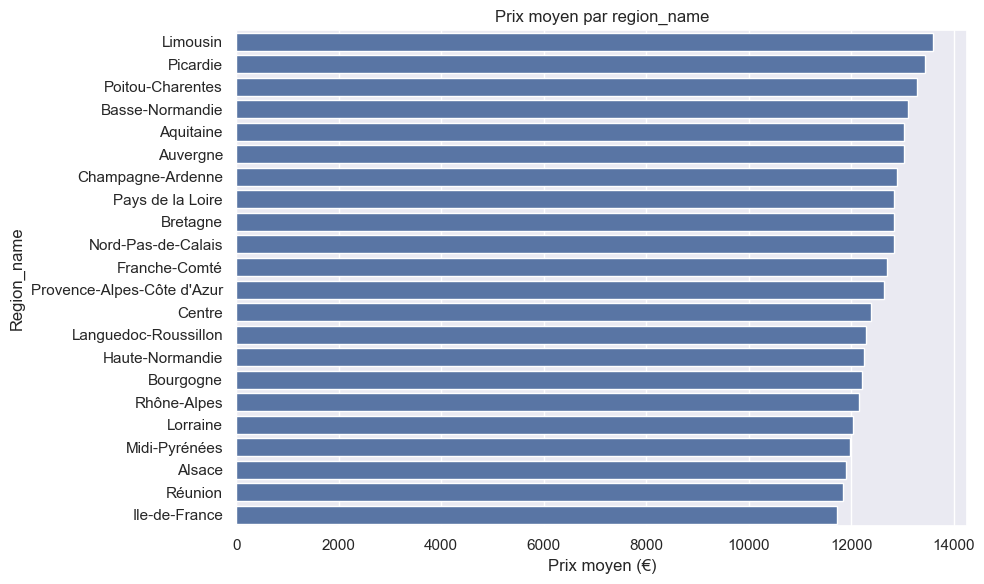

In [12]:
# Appeler la fonction plot_avg_price pour visualiser le prix moyen par région
plot_avg_price(data=data, category_col='region_name', value_col='price', method='mean', min_count=100,top_n=30)

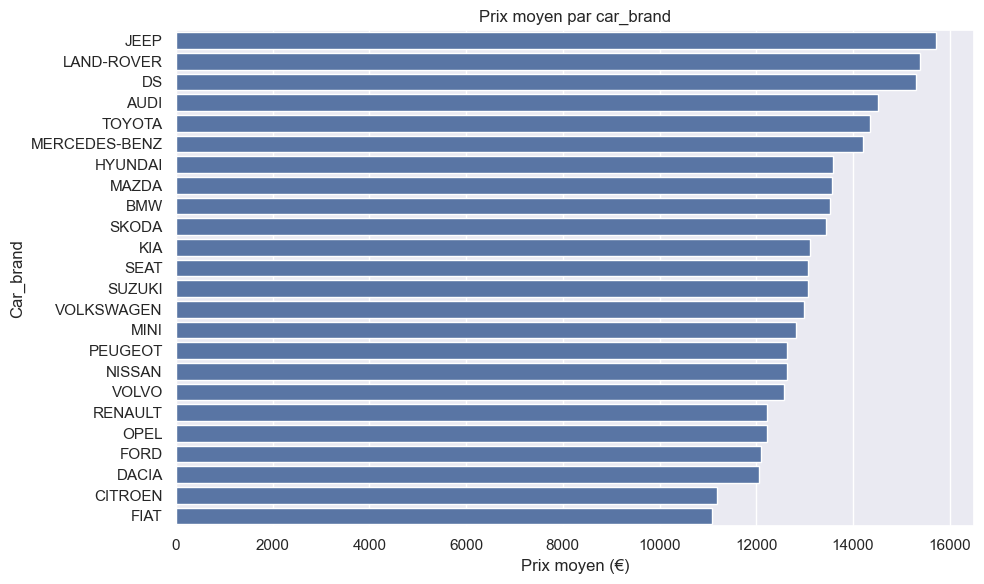

In [13]:
# Appeler la fonction plot_avg_price pour visualiser le prix moyen par marque voiture
plot_avg_price(data=data, category_col='car_brand', value_col='price', method='mean', min_count=50,top_n=40)

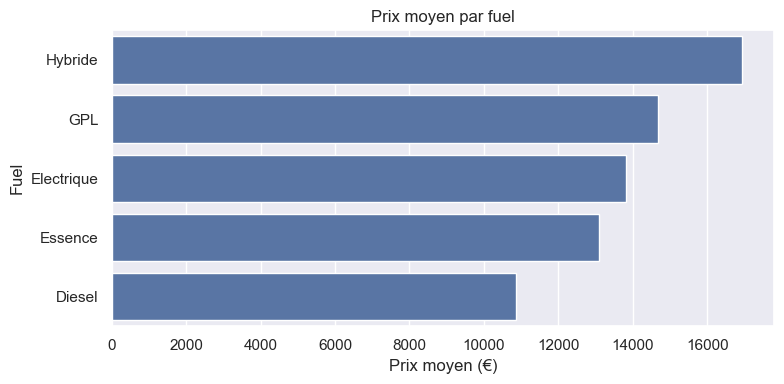

In [14]:
# Appeler la fonction plot_avg_price pour visualiser le prix moyen par type de carburant voiture
plot_avg_price(data=data, category_col='fuel', value_col='price', min_count=100, method='mean',figsize=(8, 4))

### Observations
___
Les graphiques précédents illustrent les distributions des prix moyens en fonction de diverses variables catégorielles (région, marque, type de carburant), ce qui permet d'analyser les tendances des prix des véhicules selon chaque modalité :

* Les prix moyens varient d'une région à l'autre.
* Les régions Île-de-France et Alsace offrent des prix plus avantageux, tandis que les régions Limousin et Picardie affichent des prix plus élevés.
* Les marques les plus coûteuses sont Jeep et Land Rover, tandis que Dacia, Citroën et Fiat sont les moins chères.
* Dans l'ensemble, les voitures hybrides sont les plus chères et les diesels sont les moins chères.



### 2.3 Évolution des prix par mois

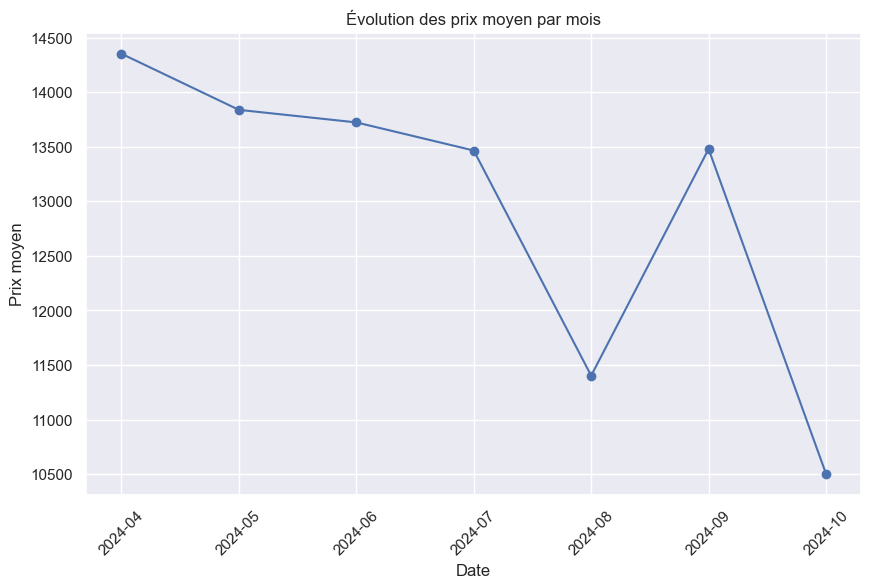

In [15]:
# Appeler la fonction pour tracer l'évolution des prix dans le temps
plot_price_evolution(data, 'first_publication_date', 'price', method='moyen', min_annonces=700)

Le graphique montre l'évolution des prix moyens par mois de avril 2024 à octobre 2024. On observe une tendance générale à la baisse des prix, avec une chute notable en août 2024 suivie d'une remontée en septembre 2024, puis une nouvelle baisse en octobre 2024.

### 2.4 Comparaison des prix moyens entre particuliers et professionnels

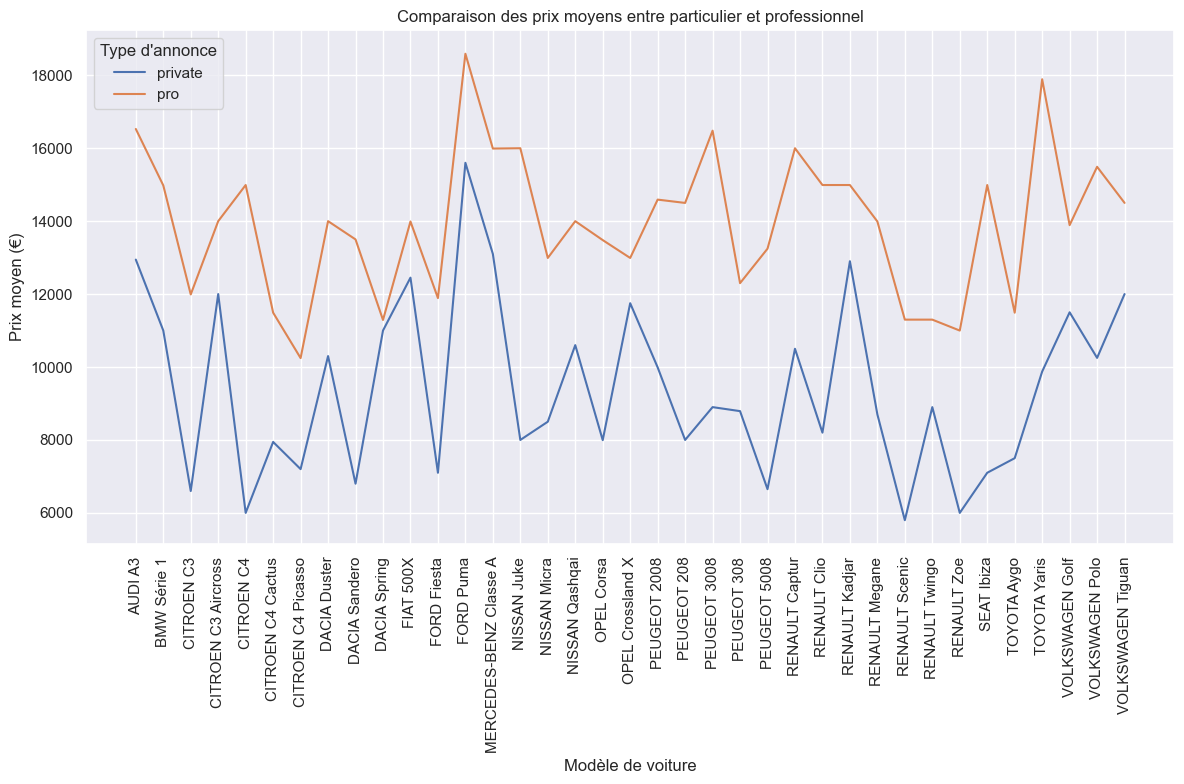

In [16]:
# Appeler la fonction pour visualiser le graphique comparatif 
plot_comparative_price(data, 'car_model', 'price', 'owner_type', min_occurrences=100)

### Remarques
---
Le graphique compare les prix moyens des voitures vendues par des vendeurs privés et professionnels :

* De manière générale, les prix des voitures chez les vendeurs professionnels sont plus élevés que ceux des vendeurs privés. Cela peut s'expliquer par la garantie offerte et une qualité de service souvent meilleure chez les professionnels.
* Les acheteurs qui cherchent à obtenir une meilleure affaire devraient envisager d'acheter certains modèles chez des particuliers, surtout pour des voitures populaires comme RENAULT ou PEUGEOT.

### 2.5 Matrice de correlation

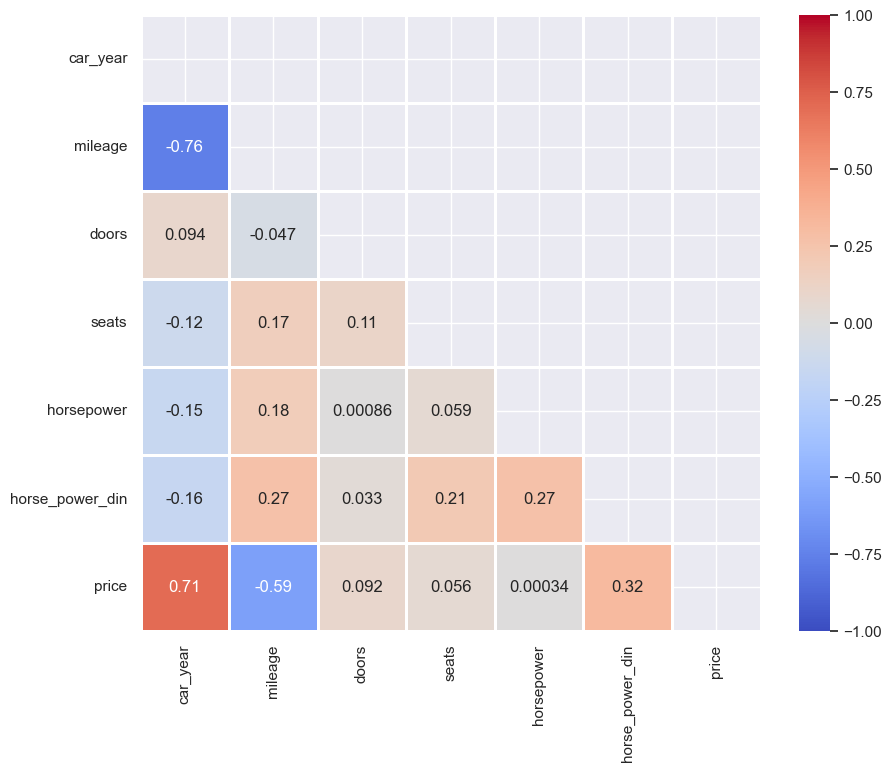

In [17]:
# Matrice de correlation
correlated_pairs = plot_correlation_matrix(data[[ 'car_year','mileage',  'doors', 'seats','horsepower',
                                                 'horse_power_din', 'price']], threshold=0.8,figsize=(10, 8))

### Conclusions
---

* La corrélation entre l'année de fabrication (car_year) et le prix (price) est de 0.71, ce qui indique une forte corrélation positive. Cela signifie que les voitures plus récentes tendent à avoir un prix plus élevé.

* La corrélation entre le kilométrage (mileage) et le prix (price) est de -0.59, ce qui indique une corrélation négative. Cela signifie que les voitures avec un kilométrage plus élevé tendent à avoir un prix plus bas.

* Il y a une corrélation négative forte entre l'année de fabrication (car_year) et le kilométrage (mileage) avec une valeur de -0.76, ce qui signifie que les voitures plus récentes tendent à avoir un kilométrage plus bas.

* La corrélation entre la puissance DIN (horse_power_din) et le prix (price) est de 0.32, ce qui indique une corrélation positive modérée. Cela signifie que les voitures avec une puissance DIN plus élevée tendent à avoir un prix plus élevé.



<a id="pretraitement"></a>
## 3. Prétraitement des données
### 3.1 Détection et gestion des valeurs aberrantes
#### 3.1.1 Colonnes Catégorielles 

In [18]:
data.describe(include='object')

,first_publication_date,status,region_name,city,owner_type,car_brand,u_car_model,fuel,gearbox,vehicle_type,vehicule_color,body,car_model
count,19050,19050,19050,19050,19050,19035,18987,19050,19050,18679,18599,19049,18987
unique,17505,1,26,3873,2,48,381,6,2,9,17,19002,388
top,2023-10-24 22:44:06,active,Ile-de-France,Saint-Quentin 02100,pro,PEUGEOT,208,Essence,Manuelle,Berline,Gris,"PEUGEOT 208 1.2 puretech 100 allure, berline, ...",PEUGEOT 208
freq,29,19050,2315,170,13784,4478,1597,9719,13557,9682,5632,3,1597


#### Gestion des valeurs aberrantes
--- 
* CAR_BRAND : Exclure les marques de voitures ayant moins de 60 occurrences dans l'ensemble des données.

* CAR_MODEL : Exclure les modèles de voitures ayant moins de 20 occurrences.

* VEHICLE_TYPE : Regrouper les catégories (Coupé, Voiture société, Commerciale, Cabriolet) dans la catégorie 'Autre'.

* REGION_NAME : Regrouper les catégories (Réunion, Martinique, Guadeloupe, Guyane) dans la catégorie 'Outre mer'.

* VEHICLE_COLOR : Regrouper les catégories rares dans la catégorie 'Autre'.

* STATUS & CITY : Ne pas inclure ces colonnes dans le modèle de machine learning.

#### Code d'application 

In [19]:
# Supprime les lignes avec des marques de voitures ayant moins de 60 occurrences
data = remove_rare_categories(data, column='car_brand', min_count=60)

# Supprime les lignes avec des modèles de voitures ayant moins de 20 occurrences
data = remove_rare_categories(data, column='car_model', min_count=20)

# Regroupe certaines régions dans la catégorie 'Outre mer'
data['region_name'] = data['region_name'].replace(['Réunion', 'Martinique', 'Guadeloupe', 'Guyane'], 'Outre mer')

# Regroupe les types de véhicules rares sous l'étiquette 'Autre' si le seuil est inférieur à 500
data = merge_categories(data, 'vehicle_type', threshold=500, other_label='Autre')

# Regroupe les couleurs de véhicules rares sous l'étiquette 'Autre' si le seuil est inférieur à 1000
data = merge_categories(data, 'vehicule_color', threshold=1000, other_label='Autre')


#### 3.1.2 Colonnes Numériques

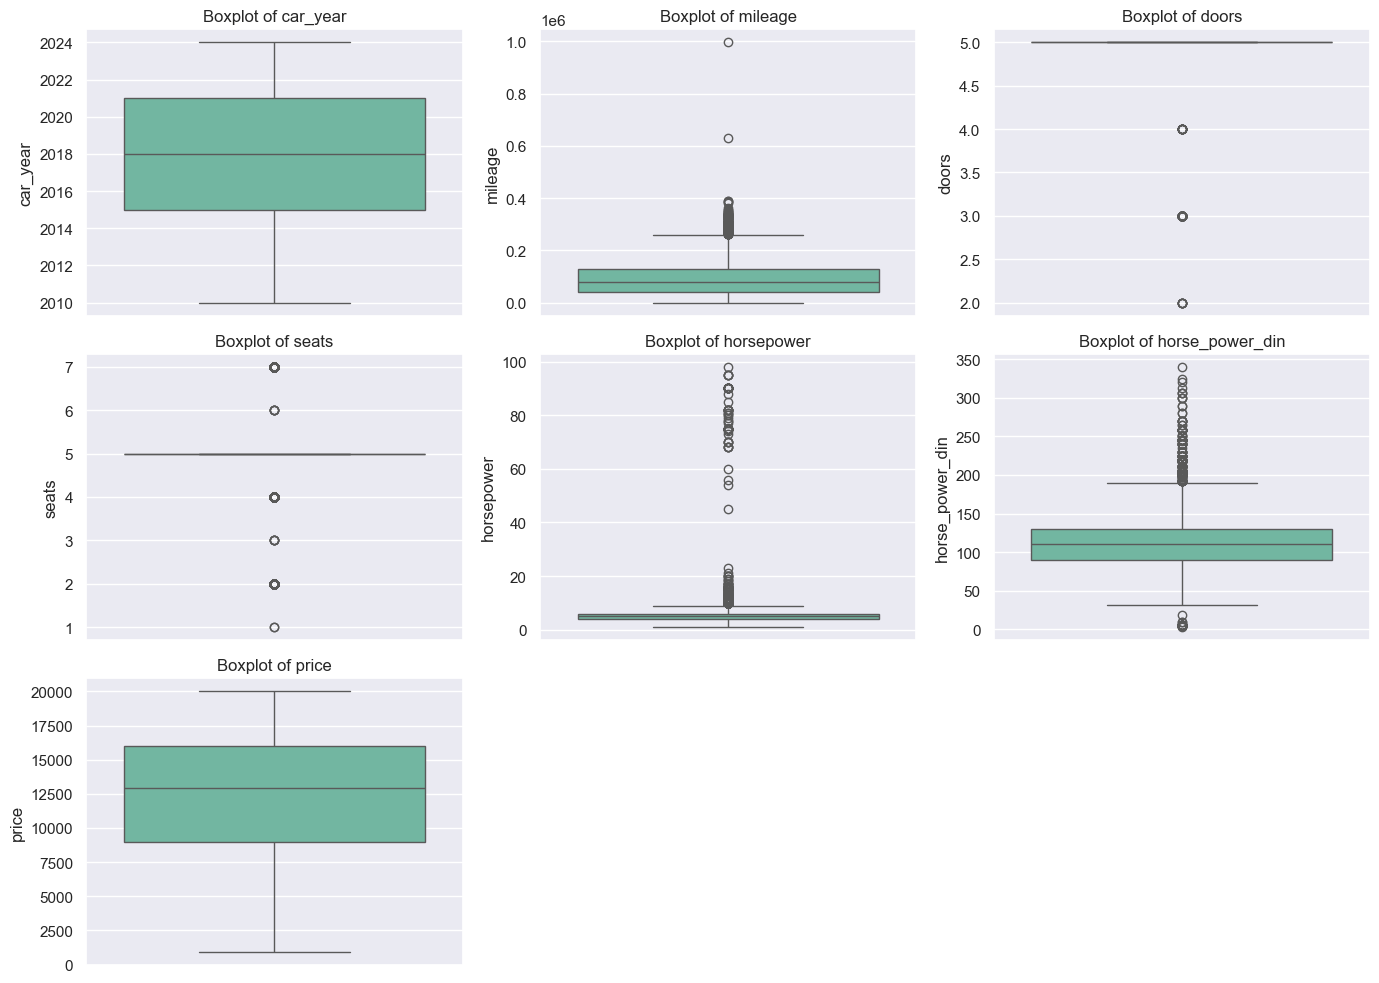

In [20]:
# Appel de la fonction pour visualiser les boxplots des colonnes numériques
plot_numeric_boxplots(data.drop('list_id',axis=1))

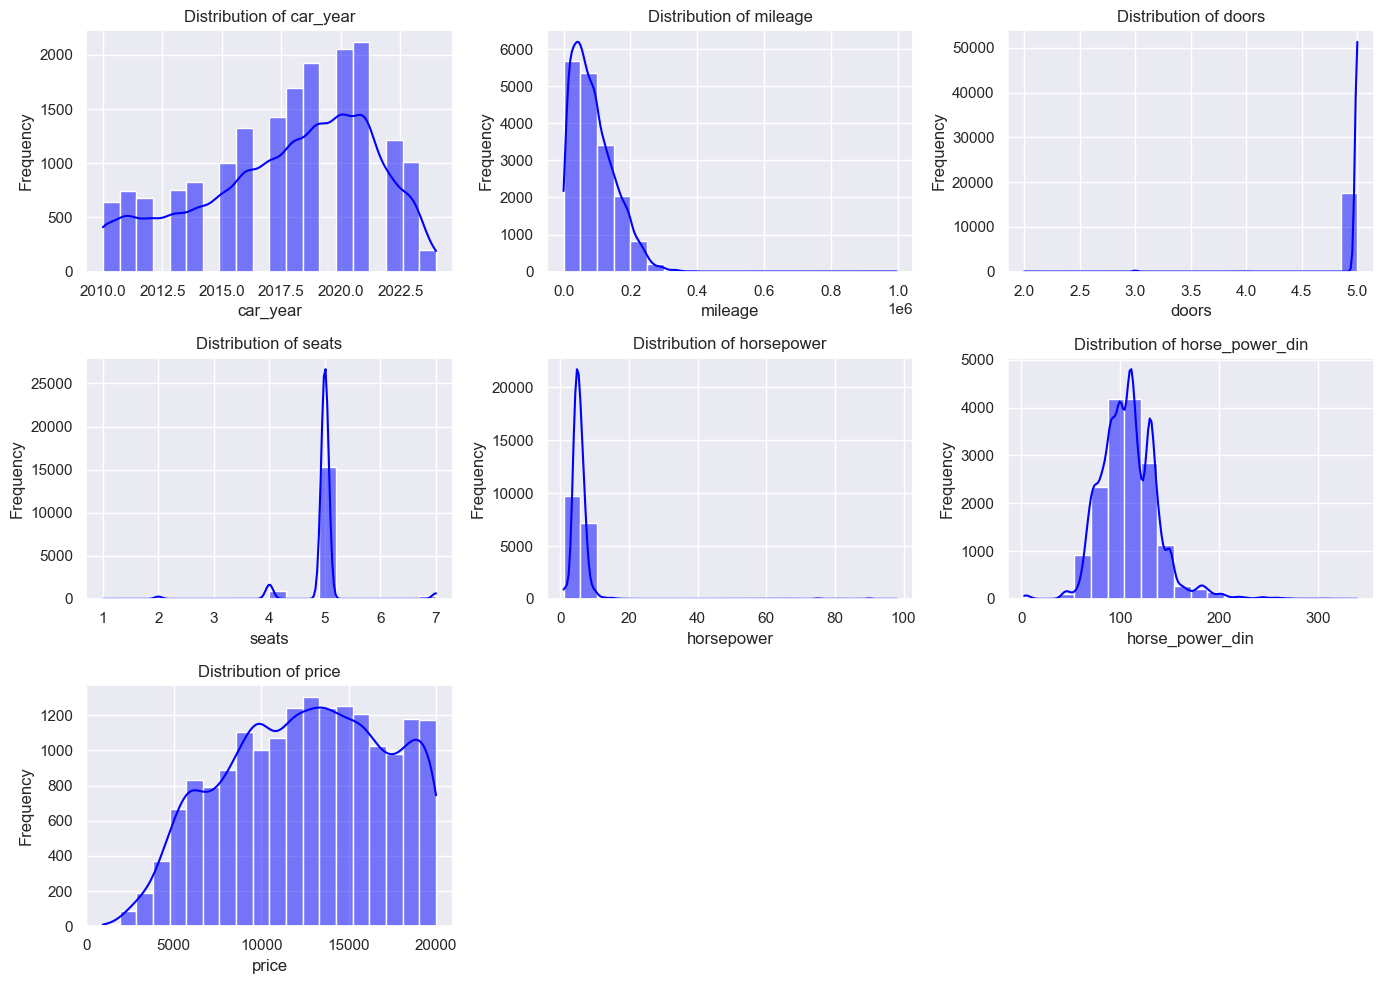

In [21]:
# Appel de la fonction pour visualiser la distribution des variables numériques
plot_numeric_distributions(data.drop('list_id',axis=1))

#### Remarques
---
* En examinant la colonne des chevaux fiscaux (horsepower), on constate des incohérences avec des valeurs dépassant 40 CV, atteignant même 100 CV. Il semble probable qu'il y ait eu une confusion avec la colonne chevaux-vapeur (horse_power_din) lors de la déclaration.

* La colonne chevaux-vapeur (horse_power_din) est normalement distribuée entre 0 et 300 Ch. Cependant, cette colonne présente aussi des anomalies, avec des valeurs inférieures à 40 Ch, probablement dues à une confusion avec les chevaux fiscaux.

* La valeur prédominante dans les colonnes "doors" et "seats" est de 5.

* Les prix des voitures se situent entre 1 000 et 20 000 euros.

#### Gestion des valeurs aberrantes
--- 

* Chevaux-vapeur (horse_power_din) : Les valeurs inférieures à 45 Ch ne seront pas prises en compte.

* Chevaux fiscaux (horsepower) : En raison de nombreuses anomalies, cette colonne ne sera pas utilisée. De plus, d'après la matrice de corrélation, elle n'a pas de corrélation avec la variable cible, contrairement à la variable horse_power_din.

* Kilométrage (mileage) : Les valeurs dépassant 400 000 kilomètres seront éliminées.

* Portes et sièges (doors et seats) : Ces colonnes ne seront pas intégrées dans l'analyse en raison de leur faible variation et de leur absence de corrélation avec le prix.

#### Code d'application 

In [23]:
# Sélection des colonnes pertinentes pour la modélisation
df = data[['car_year', 'mileage','horse_power_din','owner_type','gearbox','fuel','car_brand',
           'region_name','car_model','vehicle_type','vehicule_color','body','price']]

# Garder les enregistrements avec un kilométrage inférieur à 400 000 km
df = df[df.mileage < 400000]

# Supprimer les enregistrements avec une puissance chevaux inférieure à 45 Ch
df = df[(df.horse_power_din > 45) | pd.isnull(df.horse_power_din)]

# Réinitialiser les index du DataFrame
df = df.reset_index(drop=True)

df.shape


(17479, 13)

### 3.2 Gestion des valeurs manquantes

In [24]:
# Appel de la fonction missing_data pour afficher les valeurs manquantes dans le jeu de données
missing_data(data= df)

,Total,Percent
horse_power_din,1144,6.5
vehicule_color,371,2.1
vehicle_type,318,1.8
car_year,0,0.0
mileage,0,0.0
gearbox,0,0.0
owner_type,0,0.0
fuel,0,0.0
car_brand,0,0.0
car_model,0,0.0


#### Gestion des valeurs manquantes
--- 
Après analyse des données, voici les stratégies pour traiter les valeurs manquantes dans le jeu de données :

* horse_power_din (puissance chevaux) : Avec 6,5 % de données manquantes, cette variable est informative pour prédire le prix des voitures (corrélation avec le prix). L’imputation sera réalisée grâce à un modèle Random Forest, capable de capturer des relations complexes et non linéaires entre les variables.

* vehicle_type (type de véhicule) : L'imputation sera effectuée en se référant au type le plus répandu pour le modèle de voiture concerné.

* vehicule_color (couleur du véhicule) : Compléter avec la valeur 'Autre'.


####  Code d'application

In [25]:
# Colonnes numériques et catégorielles utilisées pour imputer les valeurs manquantes de horse_power_din
numerical_columns = ['car_year']
categorical_columns = ['car_model', 'fuel', 'gearbox']

# Appeler la fonction pour imputer les valeurs manquantes de horse_power_din
df = impute_with_random_forest(df, target_column='horse_power_din', numerical_columns=numerical_columns, categorical_columns=categorical_columns)

# Remplacer les valeurs manquantes de vehicle_type en utilisant car_model comme référence
df = impute_by_car_model(df, 'vehicle_type', reference_column='car_model')

# Remplacer les valeurs manquantes dans vehicule_color par 'Autre'
df['vehicule_color'] = df['vehicule_color'].fillna('Autre')


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17479 entries, 0 to 17478
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   car_year         17479 non-null  int64  
 1   mileage          17479 non-null  int64  
 2   horse_power_din  17479 non-null  float64
 3   owner_type       17479 non-null  object 
 4   gearbox          17479 non-null  object 
 5   fuel             17479 non-null  object 
 6   car_brand        17479 non-null  object 
 7   region_name      17479 non-null  object 
 8   car_model        17479 non-null  object 
 9   vehicle_type     17479 non-null  object 
 10  vehicule_color   17479 non-null  object 
 11  body             17479 non-null  object 
 12  price            17479 non-null  int64  
dtypes: float64(1), int64(3), object(9)
memory usage: 1.7+ MB


### 3.3 Extraction Informations Supplémentaires 

Nous allons utiliser une fonction pour analyser la colonne de texte des descriptions d'annonces et extraire des informations additionnelles afin d'enrichir nos données. Cette fonction convertira le texte en minuscules, supprimera les caractères spéciaux, et recherchera des motifs spécifiques tels que l'état général, l'entretien, les équipements, et autres caractéristiques importantes. Cela permettra d'améliorer l'analyse et la précision de notre modèle.

In [27]:
# Définir les motifs à rechercher
patterns = {
    'etat_general': r'(comme neuf|excellent état|très bon état|usure)',
    'entretien': r'(entretien complet|révision faite|vidange faite|pneus neufs|batterie neuve)',
    'equipements': r'(gps|système de navigation|caméra de recul|climatisation|toit ouvrant|bluetooth|radar de recul)',
}

df_additional_info = df['body'].apply(lambda x: extract_additional_information(x, patterns=patterns)).apply(pd.Series)

In [28]:
# Concaténer les nouvelles colonnes avec le DataFrame original
df = pd.concat([df, df_additional_info.loc[:, ~df_additional_info.columns.isin(df.columns)]], axis=1)

# Supprimer la colonne 'body' 
if 'body' in df.columns:
    df.drop('body', axis=1, inplace=True)


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17479 entries, 0 to 17478
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   car_year         17479 non-null  int64  
 1   mileage          17479 non-null  int64  
 2   horse_power_din  17479 non-null  float64
 3   owner_type       17479 non-null  object 
 4   gearbox          17479 non-null  object 
 5   fuel             17479 non-null  object 
 6   car_brand        17479 non-null  object 
 7   region_name      17479 non-null  object 
 8   car_model        17479 non-null  object 
 9   vehicle_type     17479 non-null  object 
 10  vehicule_color   17479 non-null  object 
 11  price            17479 non-null  int64  
 12  etat_general     1287 non-null   object 
 13  entretien        819 non-null    object 
 14  equipements      14245 non-null  object 
dtypes: float64(1), int64(3), object(11)
memory usage: 2.0+ MB


### 3.4 Encodage des variables catégorielles

Le traitement des variables catégorielles varie en fonction de plusieurs facteurs, tels que la nature des données, le type de modèle et le nombre de catégories. Pour maintenir un bon équilibre entre interprétabilité et performance dans les modèles de régression, nous utilisons l'encodage one-hot. Cette méthode convertit les catégories en variables binaires.

In [30]:
# Identifier les colonnes catégorielles
df_cat_columns = df.select_dtypes(include=['object', 'category']).columns

# Effectuer l'encodage One-Hot
df_encoded = process_categorical(df, df_cat_columns, encoding_method='onehot')

# Afficher la taille des données encodées
print(f"Taille des données : {df_encoded.shape}")


Taille des données : (17479, 201)


### 3.5 Séparation des données 

Nous divisons les données en ensembles d'entraînement et de test pour évaluer la performance du modèle sur des données non vues. Pour garantir une répartition équilibrée des catégories de la variable car_model dans les ensembles d'entraînement et de test, nous devons utiliser un processus de stratification.

In [31]:
# Créer une colonne pour représenter les catégories à stratifier
df_encoded['stratify_col'] = df_encoded.filter(like='car_model_').idxmax(axis=1)

# Séparer les données en variables explicatives et en variable cible
X = df_encoded.drop(columns=['price', 'stratify_col'])
y = df_encoded['price']

# Diviser les données en ensembles d'entraînement et de test avec stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=df_encoded['stratify_col'], random_state=77)

# Afficher la taille des ensembles d'entraînement et de test
print(f"Taille de l'ensemble d'entraînement : {X_train.shape}")
print(f"Taille de l'ensemble de test : {X_test.shape}")


Taille de l'ensemble d'entraînement : (13983, 200)
Taille de l'ensemble de test : (3496, 200)


<a id="modelisation"></a>
## 4. Modélisation
### 4.1  Apprentissage des Modèles
Mise en place de plusieurs modèles de régression pour prédire le prix des voitures :

In [35]:
# Liste des modèles de régression à tester
models = {
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(),
        'Lasso': Lasso(),
        'RandomForest': RandomForestRegressor(),
        'Decision Tree Regressor':DecisionTreeRegressor(),
        'Gradient Boosting Regressor':GradientBoostingRegressor(),
        'KNeighbors Regressor': KNeighborsRegressor(n_neighbors = 5),
        'Support Vector Rregression':SVR()
         }  

# Comparaison des modèles de régression
performance_table = compare_regression_models(models,X_train, X_test, y_train, y_test)
performance_table

100%|██████████| 8/8 [21:12<00:00, 159.12s/it]


,Model,Mean Absolute Error (Train),R²/Accuracy (Train),Mean Absolute Error (Test),R²/Accuracy (Test)
0,LinearRegression,1253,0.87,1246,0.87
1,Ridge,1254,0.87,1246,0.87
2,Lasso,1266,0.87,1258,0.87
3,RandomForest,1189,0.87,1138,0.89
4,Decision Tree Regressor,1618,0.76,1536,0.78
5,Gradient Boosting Regressor,1338,0.85,1317,0.86
6,KNeighbors Regressor,2635,0.45,2553,0.49
7,Support Vector Rregression,3385,0.21,3333,0.24


Le tableau compare les performances de différents modèles de régression en termes d'erreur (Mean Absolute Error) et Accuracy sur les ensembles d'entraînement et de test :

* Régression Linéaire et Ridge: affichent des performances similaires avec une erreur moyenne absolue d'environ 1250 euros par prédiction et une accuracy de 87 % sur les ensembles d'entraînement et de test, montrant une bonne capacité de prédiction et de généralisation.

* Random Forest se distingue comme le modèle le plus performant avec un MAE de 1138 euros et un R² de 0.89 pour l'ensemble de test.

* Les autres modèles sont moins intéressants.

* Nous optons pour le modèle Ridge non seulement pour ses bonnes performances, mais aussi pour sa simplicité, sa facilité d'interprétation et sa capacité de généralisation.

### 4.2 Optimiser Hyperparamètres Modèle

In [36]:
# Définir le modèle Ridge et la grille des hyperparamètres 
model = Ridge()

param_grid = {
    'alpha': [ 0.1, 1.0, 10.0, 100.0],  # Coefficient de régularisation
    'fit_intercept': [True, False],    # Inclure ou non l'ordonnée à l'origine
    'solver': ['auto', 'svd', 'cholesky', 'lsqr']  # Méthodes de résolution
}
# Optimiser le modèle avec GridSearchCV 
meilleur_model, meilleur_score = optimize_model(model, param_grid, X_train, y_train , cv=5, scoring='r2')

print(f"Meilleur Modèle: {meilleur_model}")
print(f"Meilleur Score R2: {meilleur_score}")


Optimisation des hyperparamètres:   3%|▎         | 1/32 [01:14<38:18, 74.16s/it]

Meilleur Modèle: Ridge(alpha=0.1)
Meilleur Score R2: 0.87


### 4.3 Visualisation Performances Modèle

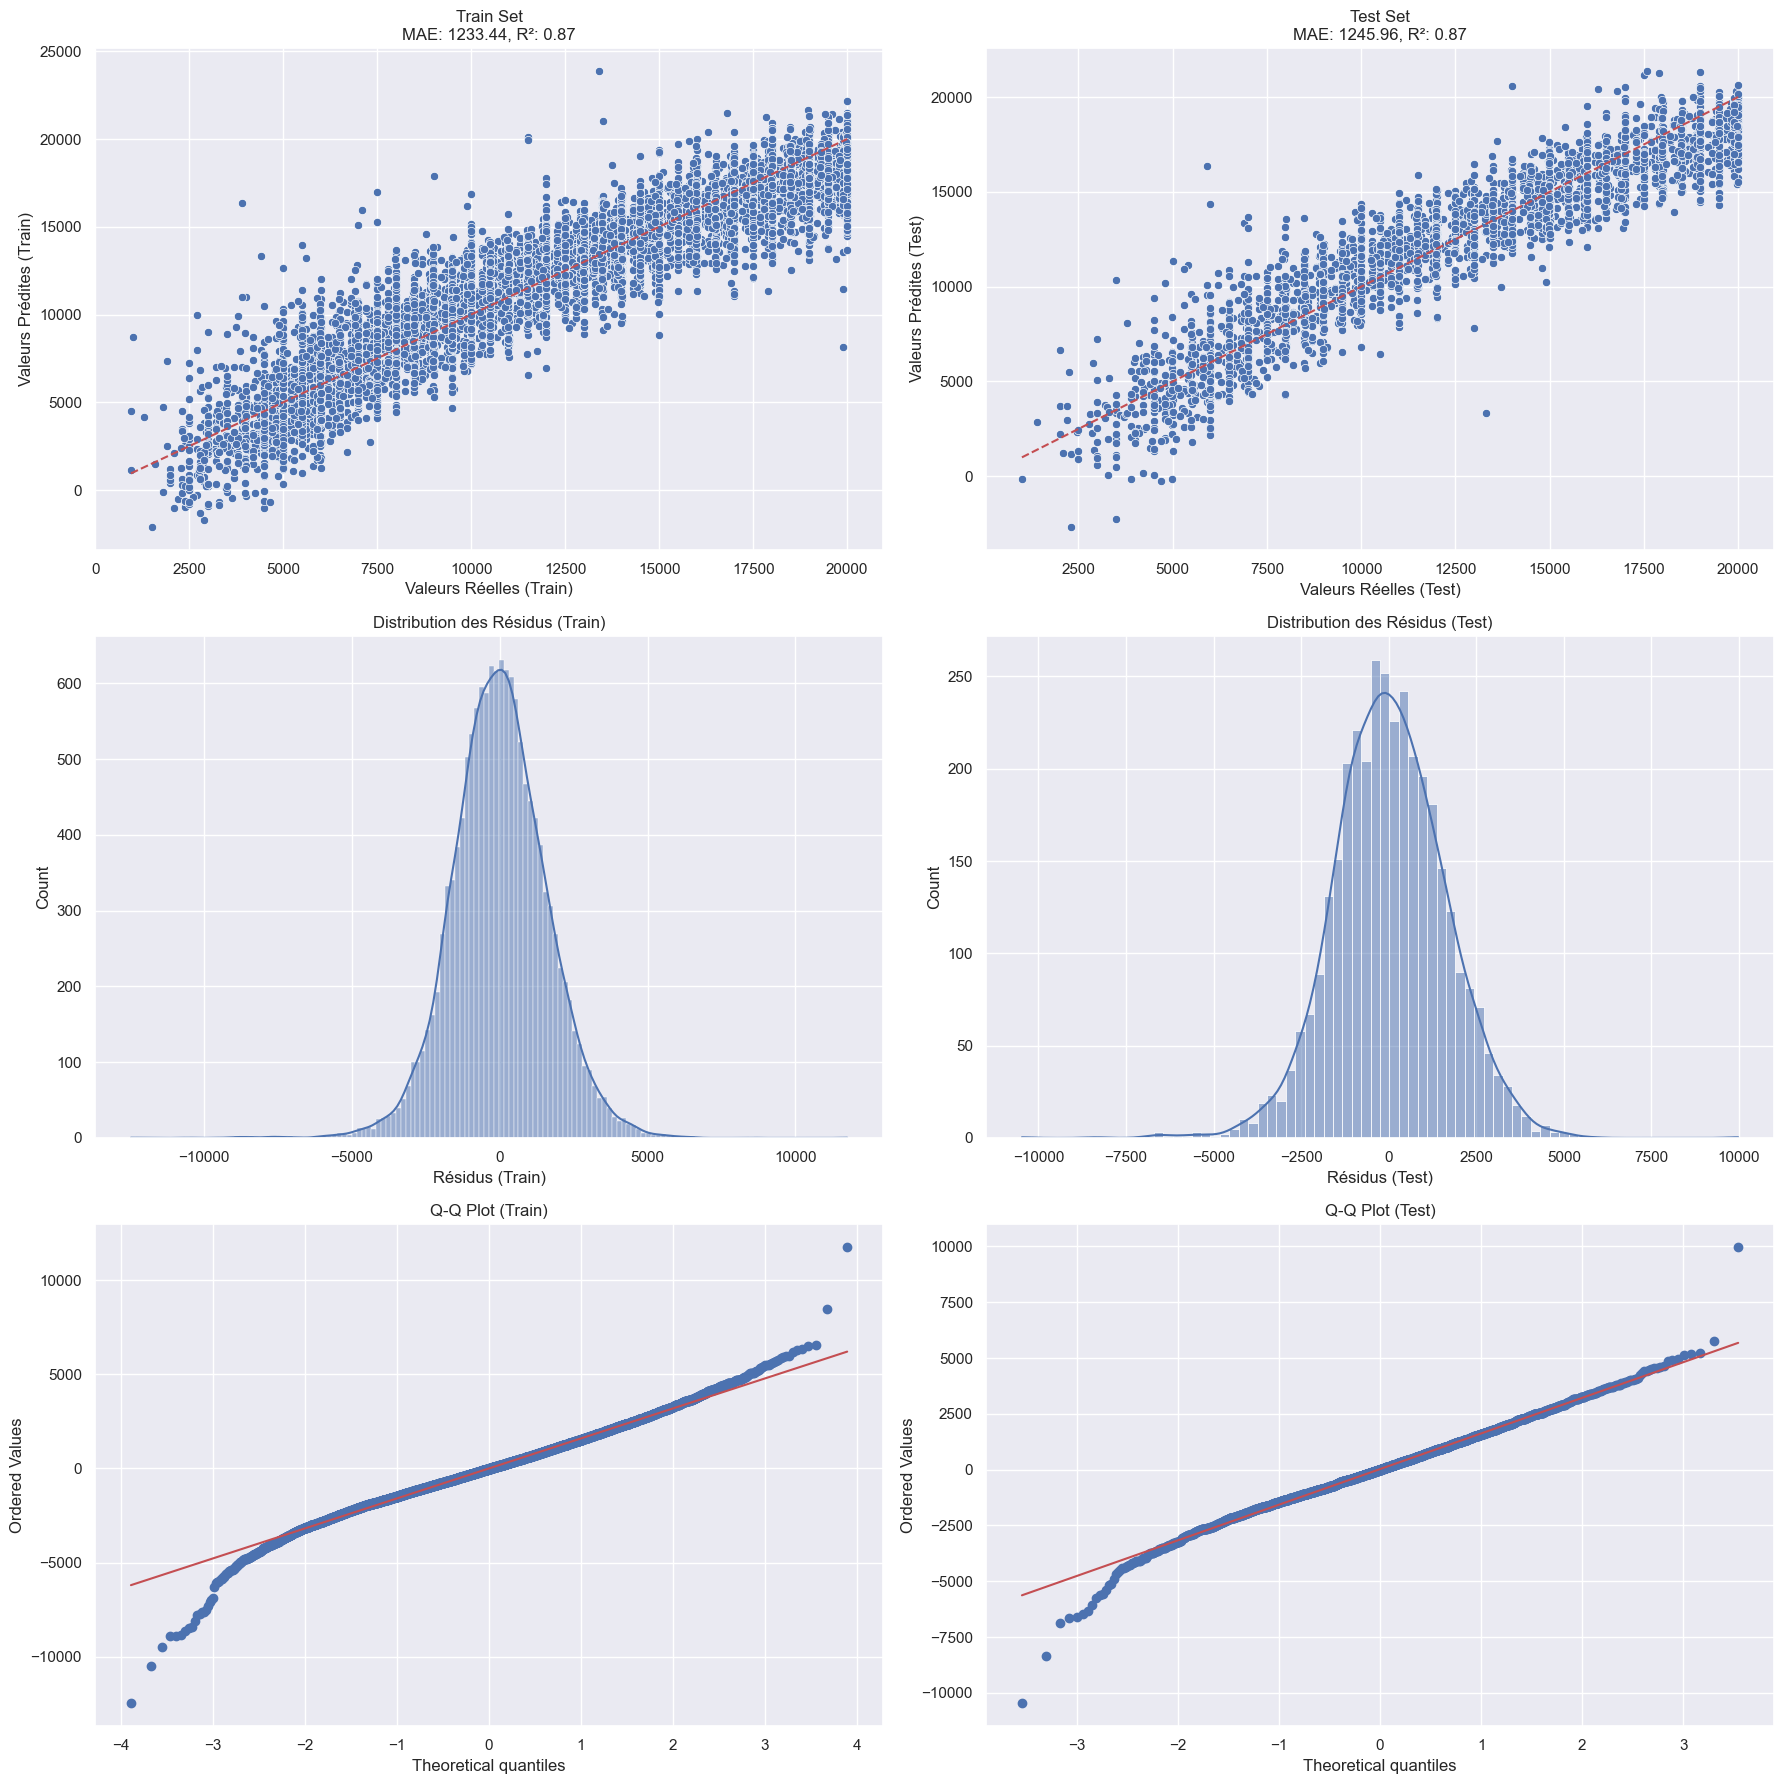

In [37]:
# Initialiser Meilleur Modèle Ridge
model = Ridge(alpha=0.1)
# Entraînement du modèle
model.fit(X_train, y_train)
# Visualiser les performances du modèle
visualize_model_performance(model, X_train, y_train, X_test, y_test,figsize=(18, 18))

#### Les performances du modèle 

* Explication de la variance : Le modèle parvient à expliquer 87 % de la variation des données. Cela signifie qu'il réussit à modéliser correctement 87 % des situations rencontrées dans les données d'entraînement et de test, démontrant ainsi une bonne capacité de prédiction et de généralisation.

* Marge d'erreur moyenne : En moyenne, le modèle affiche une marge d'erreur de 1240 euros par prédiction. Les erreurs de prédiction sont bien réparties autour de zéro, la majorité se situant dans une plage de [-2500 euros à 2500 euros].

* Analyse des résidus : le graphique Q-Q Plot montre que les résidus suivent globalement une distribution normale. Cela suggère que les hypothèses de normalité des erreurs sont respectées, ce qui est un bon indicateur de la robustesse du modèle. Cependant, quelques outliers sont présents aux extrémités, indiquant des prédictions moins précises pour certaines observations atypiques.

<a id="resultas"></a>
## 5. Interprétation des résultats
### 5.1 Impact des Variables sur les Prédictions

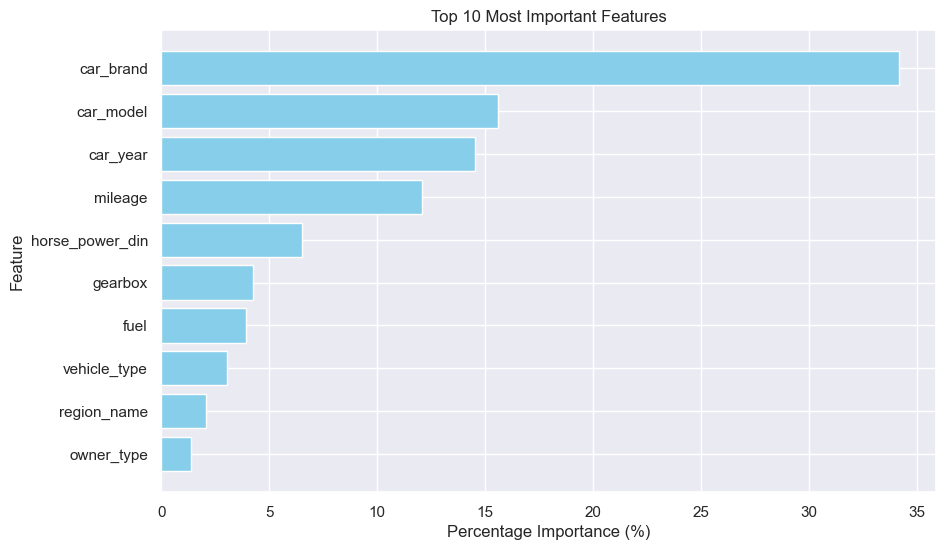

In [38]:
# Colonnes originales avant encodage
original_columns = df_cat_columns  
# Visualisation des caractéristiques importantes 
importance_df = plot_feature_importance(model, X, original_columns, top_n=10, model_type='linear')

Le graphique montre les 10 caractéristiques les plus influentes pour le modèle de prédiction des prix des voitures. La marque de la voiture est la plus déterminante, suivie du modèle, de l'année de fabrication et du kilométrage. Les autres facteurs ont une importance moindre, mais contribuent néanmoins aux prédictions.

### 5.2  Analyse et Interprétation des Coefficients


### Impact des Marques de Voitures sur le Prix

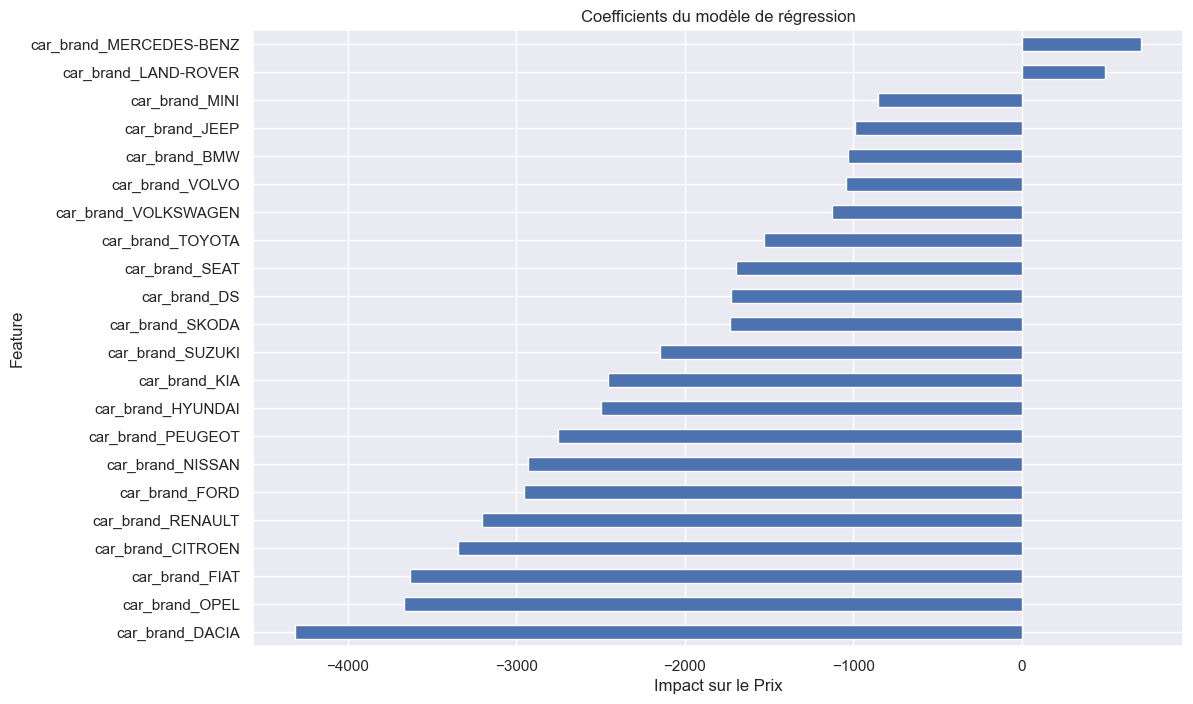

In [39]:
# Visualiser les coefficients de la variable 'car_brand'
visualize_coefficients(model, X, columns=['car_brand'], top_n=30)

Ce graphique montre l'impact relatif des marques de voitures sur la prédiction des prix. Les marques comme MERCEDES-BENZ et LAND-ROVER, avec des coefficients élevés, tendent à augmenter significativement le prix des voitures. À l'inverse, les marques telles que DACIA, OPEL, FIAT et CITROEN ont des coefficients très négatifs, indiquant qu'elles sont associées à des voitures moins chères. Par exemple, DACIA a le coefficient le plus bas, environ -4000 euros, suggérant que ses voitures sont les moins chères du marché. Cette distinction entre les marques reflète bien la segmentation du marché automobile, séparant les véhicules haut de gamme avec des standards élevés en termes de performance et des véhicules de basse et moyenne gamme.

### Impact des Modèles de Voitures sur le Prix

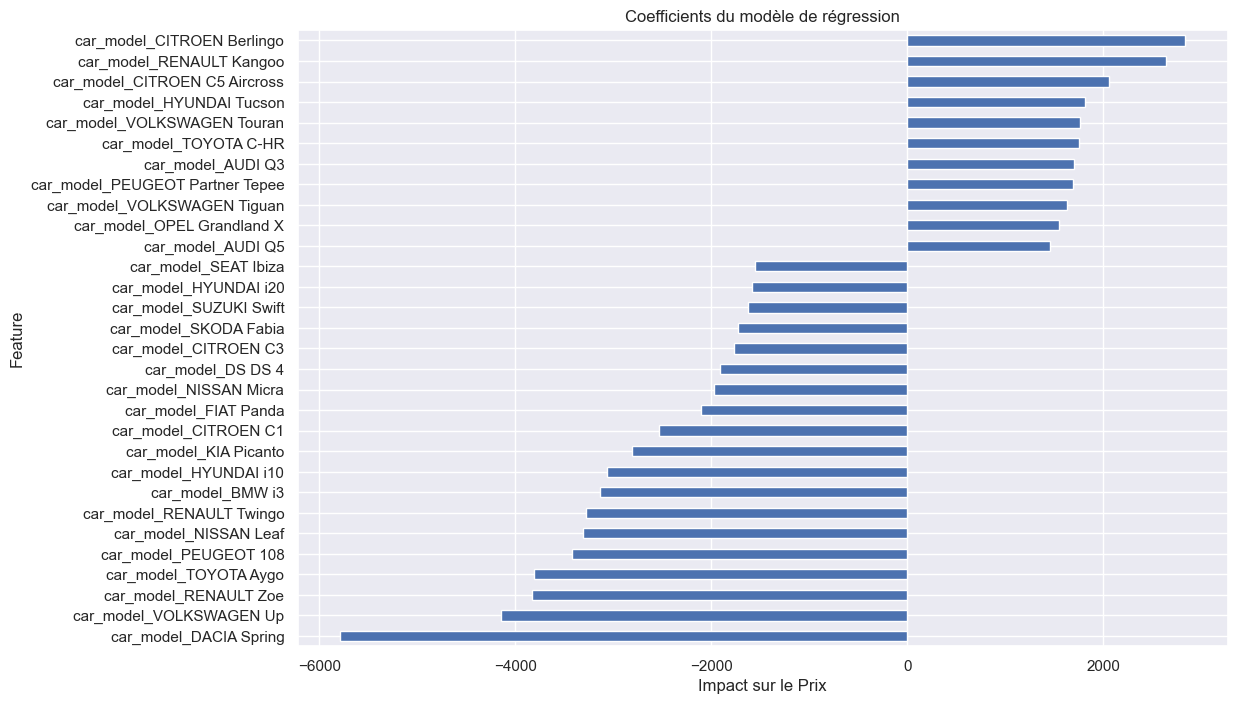

In [40]:
# Visualiser les coefficients de la variable 'car_model'
visualize_coefficients(model, X, columns=['car_model'], top_n=30)

Les modèles tels que RENAULT Kangoo, CITROËN Berlingo et Citroën C5 ont des coefficients très élevés, indiquant qu'ils augmentent significativement le prix des voitures en moyenne. Ces véhicules sont souvent plus coûteux en raison de leur taille, leur polyvalence et leurs capacité de chargement.
En revanche, des modèles comme DACIA Spring, VOLKSWAGEN Up et RENAULT Zoe se trouvent dans la partie inférieure du graphique avec des coefficients très négatifs, suggérant qu'ils sont associés à des voitures moins chères.

### Impact la localisation géographique sur le Prix

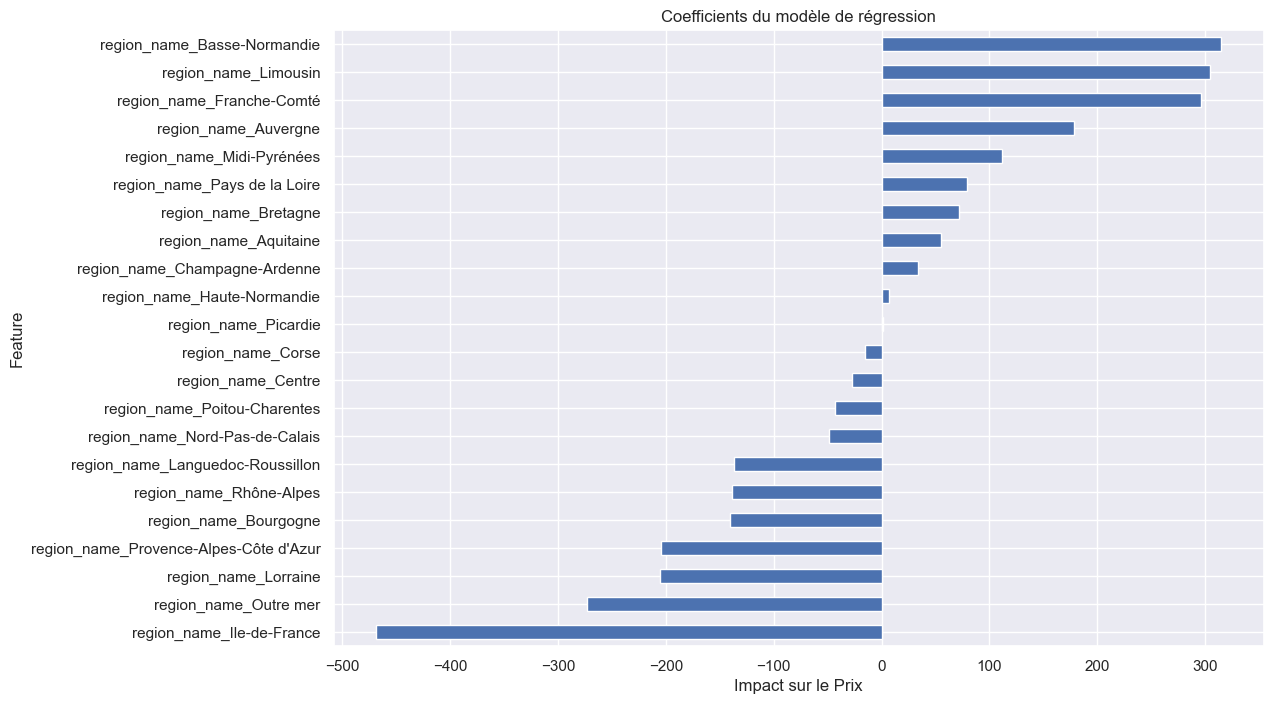

In [41]:
# Visualiser les coefficients de la variable 'region_name'
visualize_coefficients(model, X, columns=['region_name'], top_n=30)

Ce graphique montre comment la localisation géographique des différentes régions de France peut influencer les prix. Les régions "Basse-Normandie" et "Limousin" affichent des prix généralement plus élevés, d'environ 300 euros de plus. En revanche, la région "Ile-de-France" est la moins chère pour acheter, avec des prix inférieurs de plus de 450 euros par rapport aux autres régions.

###  Impact d'Autres Variables (Année, Kilométrage, etc.)

In [42]:
# Récupérer les coefficients du modèle
coefficients = model.coef_
# Créer un DataFrame pour les coefficients
coef_df = pd.DataFrame({'Variable': X_train.columns,'Coefficient': coefficients})
# Afficher 10 coefficients
coef_df[:10]

,Variable,Coefficient
0,car_year,661.834235
1,mileage,-0.032244
2,horse_power_din,39.711360
3,owner_type_pro,483.830260
4,gearbox_Manuelle,-1271.392219
5,fuel_Diesel,836.248553
6,fuel_Electrique,121.101225
7,fuel_Essence,-91.336924
8,fuel_GPL,-166.466107
9,fuel_Hybride,866.432584


* Année de Fabrication (car_year) :

En général, plus une voiture est récente, plus elle est chère. Le coefficient associé à l'année est positif, confirmant que les voitures récentes ont un prix plus élevé. 
Pour chaque année supplémentaire fait grimper le prix de la voiture d'environ 660 euros.

* Kilométrage (mileage) :

Le kilométrage est un facteur négatif. Les voitures avec un kilométrage élevé sont plus usées et nécessitent potentiellement plus de maintenance, ce qui diminue leur valeur. Ainsi, le coefficient du kilométrage dans le modèle a une valeur de -0.032, indiquant que chaque 10 000 kilomètres supplémentaires réduit le prix du véhicule de 320 euros.



* Puissance du Moteur (horse_power_din) :

Chaque ajout de 10 chevaux DIN entraîne une augmentation du prix de la voiture d'environ 400 euros.
Cela s'explique par le fait que les voitures plus puissantes, sont généralement plus valorisées sur le marché.

* Type de Vendeur (Professionnel vs Particulier) :

Les voitures vendues par des professionnels voient leur prix augmenter d'environ 480 euros par rapport à celles vendues par des particuliers. Les vendeurs professionnels peuvent justifier un prix plus élevé en raison de la garantie offerte, et de la sécurité supplémentaire que cela apporte aux acheteurs.

* Type de Carburant :
 
Les voitures diesel coûtent environ 830 euros de plus que celles utilisant d'autres types de carburant, un écart qui s'explique souvent par la durabilité accrue des moteurs diesel et leur consommation de carburant plus économique. Cependant, cela semble contradictoire par rapport à l'analyse exploratoire, qui montre que le prix moyen des voitures essence est plus élevé que celui des voitures diesel. Cette différence suggère que, bien que les voitures essence soient en moyenne plus chères dans l'ensemble des données, le modèle de régression indique que, à caractéristiques égales (telles que marque, année, kilométrage), une voiture diesel est estimée à environ 830 € de plus qu'une voiture utilisant d'autres carburants.
En ce qui concerne les voitures hybrides, elles présentent une augmentation de prix d'environ 866 euros, probablement en raison de la demande croissante pour des véhicules plus écologiques.

### Conclusion

Nous avons mené une analyse des données sur LeBonCoin, ciblant des voitures d'occasion à moins de 20 000 euros et fabriquées après 2010. Cette focalisation a permis de délimiter notre étude à un segment précis du marché, excluant les véhicules de luxe comme Ferrari ou Porsche. En conséquence, les résultats obtenus ne peuvent être généralisés à l'ensemble du marché automobile, et encore moins aux segments haut de gamme.

Notre modèle de régression linéaire a expliqué une grande partie de la variance des prix des voitures, avec un coefficient de détermination (R²) supérieur à 87 %. Néanmoins, il reste des améliorations possibles, notamment en intégrant des variables comme l'état du véhicule, analysé via des modèles de Deep Learning à partir d'images, ainsi que des données sur l'historique d'entretien.

Le manque de données sur une période plus longue a limité notre capacité à analyser les variations saisonnières et les fluctuations des prix. Une telle analyse pourrait aider à identifier les périodes les plus avantageuses pour l'achat d'une voiture d'occasion, offrant ainsi des informations précieuses pour optimiser les achats.

Les résultats de cette analyse fournissent une base solide pour avoir une vue d'ensemble du marché et tirer des conclusions sur son état actuel. Pour aller plus loin, il serait utile de combiner ces travaux avec une analyse détaillée des descriptions d'annonces à l'aide de modèles de traitement du langage naturel (LLMs), puis de présenter les résultats dans une interface graphique permettant des recherches spécifiques.